In [1]:
import skimage
import os
from skimage import io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.color import rgb2hsv
import re
import numpy as np
import seaborn as sns
## for the stats class
import scipy.signal as sg
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.decomposition import SparsePCA
import pywt
from scipy import stats
import timeit 
#import optshrink as opt # package we create
import numpy as np
# import scipy.io as sio
import h5py
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import pandas as pd
from datetime import datetime
import pytz
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from skimage import io
from patchify import patchify, unpatchify



import collections
# from itertools import chain
# import urllib.request as request
# import pickle 

import numpy as np

import scipy.signal as signal
import scipy.special as special
import scipy.optimize as optimize

import matplotlib.pyplot as plt

import skimage.io
import skimage.transform

# import cv2

# from libsvm import svmutil

import Shady.Contrast as sc 

In [2]:

# https://github.com/ocampor/notebooks/blob/master/notebooks/image/quality/brisque.ipynb
def normalize_kernel(kernel):
    return kernel / np.sum(kernel)

def gaussian_kernel2d(n, sigma):
    Y, X = np.indices((n, n)) - int(n/2)
    gaussian_kernel = 1 / (2 * np.pi * sigma ** 2) * np.exp(-(X ** 2 + Y ** 2) / (2 * sigma ** 2)) 
    return normalize_kernel(gaussian_kernel)

def local_mean(image, kernel):
    return signal.convolve2d(image, kernel, 'same')


def local_deviation(image, local_mean, kernel):
    "Vectorized approximation of local deviation"
    sigma = image ** 2
    sigma = signal.convolve2d(sigma, kernel, 'same')
    return np.sqrt(np.abs(local_mean ** 2 - sigma))


def calculate_mscn_coefficients(image, kernel_size=6, sigma=7/6):
    C = 1/255
    kernel = gaussian_kernel2d(kernel_size, sigma=sigma)
    local_mean = signal.convolve2d(image, kernel, 'same')
    local_var = local_deviation(image, local_mean, kernel)
    
    return (image - local_mean) / (local_var + C)

def calculate_pair_product_coefficients(mscn_coefficients):
    return collections.OrderedDict({
        'mscn': mscn_coefficients,
        'horizontal': mscn_coefficients[:, :-1] * mscn_coefficients[:, 1:],
        'vertical': mscn_coefficients[:-1, :] * mscn_coefficients[1:, :],
        'main_diagonal': mscn_coefficients[:-1, :-1] * mscn_coefficients[1:, 1:],
        'secondary_diagonal': mscn_coefficients[1:, :-1] * mscn_coefficients[:-1, 1:]
    })

In [5]:
image_dir = 'all_surfline_photos/'

image_files = os.listdir(image_dir) 
print(len(image_files))

photo_links = pd.DataFrame({'photo' : image_files})
# photo_info = pd.DataFrame({'project_files_location' : project_files, 'photo_size' : size})
# photo_info.to_csv('/home/smmrrr/Fog_Imaging_Project/all_photos_link.csv', index = False)
photo_links

FileNotFoundError: [Errno 2] No such file or directory: 'all_surfline_photos/'

In [3]:
photo_labels = pd.read_csv('~/Documents/STA_221/surfline_photo_labels.csv')[['Url', 'Label', 'LabelConfidence', 'photo']]
photo_labels.loc[photo_labels['Label'] != 'uncertain']

# # photo_links
links_and_labels = photo_links.merge(photo_labels, how = 'right'
                        , on = 'photo')


image_files_summary = links_and_labels['photo'].str.split(r'[\.|\_|\-]',expand = True)

image_files_summary
image_files_summary.columns = ['year', 'month', 'day', 'hour','site', 'ext', 't', 'tt']
# image_files_summary['filename'] = image_files
image_files_summary['ext'].unique()
links_and_labels = pd.concat([links_and_labels, image_files_summary], axis = 1 )

# links_and_labels = links_and_labels.loc[links_and_labels['ext'] =='jpg']
links_and_labels['year'] = links_and_labels['year'].astype(int)
links_and_labels['day']=links_and_labels['day'].astype(int)
links_and_labels['hour']=links_and_labels['hour'].astype(int)
links_and_labels['month']=links_and_labels['month'].astype(int)

links_and_labels['hour']=np.round(links_and_labels['hour']/100).astype(int) 

links_and_labels['time'] = links_and_labels.apply(lambda row: datetime(row['year'], row['month'], row['day'], row['hour']), axis=1)


# # Specify the original timezone (if different from system timezone)
original_timezone = pytz.timezone('US/Central')

# # Convert to Pacific Time
pacific_timezone = pytz.timezone('US/Pacific')
links_and_labels['time_pst'] = links_and_labels['time'].dt.tz_localize(original_timezone).dt.tz_convert(pacific_timezone)

links_and_labels['Label'] = links_and_labels['Label'].str.lower()
links_and_labels

,photo,Url,Label,LabelConfidence,year,month,day,hour,site,ext,t,tt,time,time_pst
0,2023_05-18.0730_agatebeachor.jpg,AmlDatastore://workspaceblobstore/UI/2023-07-1...,not_foggy,1,2023,5,18,7,agatebeachor,jpg,None,None,2023-05-18 07:00:00,2023-05-18 05:00:00-07:00
1,2023_05-03.1930_agatebeachor.jpg,AmlDatastore://workspaceblobstore/UI/2023-07-1...,not_foggy,1,2023,5,3,19,agatebeachor,jpg,None,None,2023-05-03 19:00:00,2023-05-03 17:00:00-07:00
2,2023_05-18.1630_agatebeachor.jpg,AmlDatastore://workspaceblobstore/UI/2023-07-1...,not_foggy,1,2023,5,18,16,agatebeachor,jpg,None,None,2023-05-18 16:00:00,2023-05-18 14:00:00-07:00
3,2023_05-18.2030_agatebeachor.jpg,AmlDatastore://workspaceblobstore/UI/2023-07-1...,not_foggy,1,2023,5,18,20,agatebeachor,jpg,None,None,2023-05-18 20:00:00,2023-05-18 18:00:00-07:00
4,2023_05-14.2330_agatebeachor.jpg,AmlDatastore://workspaceblobstore/UI/2023-07-1...,uncertain,1,2023,5,14,23,agatebeachor,jpg,None,None,2023-05-14 23:00:00,2023-05-14 21:00:00-07:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8932,2022_09-28.2100_otterrockor.jpg,AmlDatastore://workspaceblobstore/UI/2023-10-2...,foggy,1,2022,9,28,21,otterrockor,jpg,None,None,2022-09-28 21:00:00,2022-09-28 19:00:00-07:00
8933,2023_08-20.1400_otterrockor.jpg,AmlDatastore://workspaceblobstore/UI/2023-10-2...,not_foggy,1,2023,8,20,14,otterrockor,jpg,None,None,2023-08-20 14:00:00,2023-08-20 12:00:00-07:00
8934,2022_08-18.1900_agatebeachor.jpg,AmlDatastore://workspaceblobstore/UI/2023-10-2...,foggy,1,2022,8,18,19,agatebeachor,jpg,None,None,2022-08-18 19:00:00,2022-08-18 17:00:00-07:00
8935,2023_06-14.1130_cannonbeach.jpg,AmlDatastore://workspaceblobstore/UI/2023-10-2...,not_foggy,1,2023,6,14,11,cannonbeach,jpg,None,None,2023-06-14 11:00:00,2023-06-14 09:00:00-07:00


In [98]:
print(links_and_labels.loc[f,'Label'])


uncertain


not_foggy


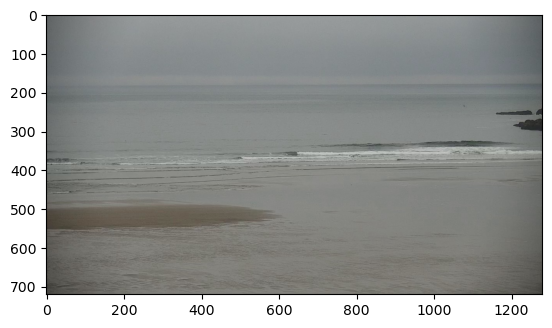

In [4]:
f = 0
im = io.imread(image_dir + links_and_labels.loc[f, 'photo']) ## read in file
print(links_and_labels.loc[f,'Label'])
plt.imshow(im)
# plt.imshow(im[:,:,2])

(720, 1280, 3)
(2, 2, 1, 360, 640, 3)


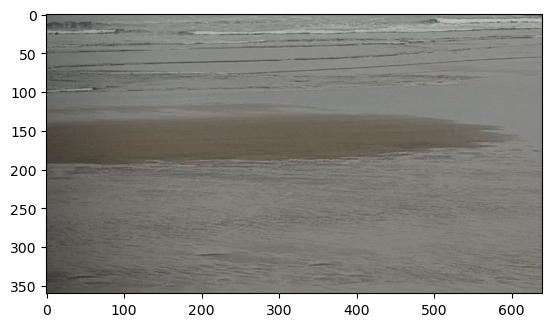

In [83]:
patchify(im, (3, 4, 3)).shape
print(im.shape)
patches = patchify(im, (360, 640, 3), (360))
print(patches.shape)
plt.imshow(patches[1, 0, 0, :,:,:])

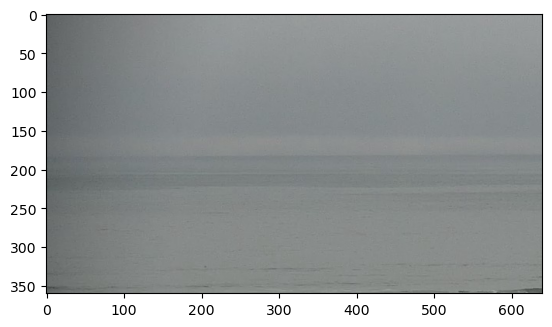

In [90]:
patches_reshape = np.reshape(patches, (2*2*1, 360, 640, 3))
patches_reshape
plt.imshow(patches_reshape[0, :,:,:])
# print(np.arange(0, 721, 240))
# print(np.arange(0, 1281, 320))
# im.shape

##divide into horizontal patches 

In [8]:
#### "cloud sensitive image metrics"

patch = im[0:239,0:319, :]
##calculating luminescence 
patch_grey = rgb2gray(patch)
print(patch.shape, ' ', patch_grey.shape)

flattened = patch_grey.ravel()
print(flattened.shape)


(239, 319, 3)   (239, 319)


In [108]:
links_and_labels_loop = links_and_labels.loc[links_and_labels['Label']!= 'uncertain'].reset_index(drop = True)

In [109]:
links_and_labels_loop

,photo,Url,Label,LabelConfidence,year,month,day,hour,site,ext,t,tt,time,time_pst
0,2023_05-18.0730_agatebeachor.jpg,AmlDatastore://workspaceblobstore/UI/2023-07-1...,not_foggy,1,2023,5,18,7,agatebeachor,jpg,None,None,2023-05-18 07:00:00,2023-05-18 05:00:00-07:00
1,2023_05-03.1930_agatebeachor.jpg,AmlDatastore://workspaceblobstore/UI/2023-07-1...,not_foggy,1,2023,5,3,19,agatebeachor,jpg,None,None,2023-05-03 19:00:00,2023-05-03 17:00:00-07:00
2,2023_05-18.1630_agatebeachor.jpg,AmlDatastore://workspaceblobstore/UI/2023-07-1...,not_foggy,1,2023,5,18,16,agatebeachor,jpg,None,None,2023-05-18 16:00:00,2023-05-18 14:00:00-07:00
3,2023_05-18.2030_agatebeachor.jpg,AmlDatastore://workspaceblobstore/UI/2023-07-1...,not_foggy,1,2023,5,18,20,agatebeachor,jpg,None,None,2023-05-18 20:00:00,2023-05-18 18:00:00-07:00
4,2023_05-30.2100_agatebeachor.jpg,AmlDatastore://workspaceblobstore/UI/2023-07-1...,not_foggy,1,2023,5,30,21,agatebeachor,jpg,None,None,2023-05-30 21:00:00,2023-05-30 19:00:00-07:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8624,2022_09-28.2100_otterrockor.jpg,AmlDatastore://workspaceblobstore/UI/2023-10-2...,foggy,1,2022,9,28,21,otterrockor,jpg,None,None,2022-09-28 21:00:00,2022-09-28 19:00:00-07:00
8625,2023_08-20.1400_otterrockor.jpg,AmlDatastore://workspaceblobstore/UI/2023-10-2...,not_foggy,1,2023,8,20,14,otterrockor,jpg,None,None,2023-08-20 14:00:00,2023-08-20 12:00:00-07:00
8626,2022_08-18.1900_agatebeachor.jpg,AmlDatastore://workspaceblobstore/UI/2023-10-2...,foggy,1,2022,8,18,19,agatebeachor,jpg,None,None,2022-08-18 19:00:00,2022-08-18 17:00:00-07:00
8627,2023_06-14.1130_cannonbeach.jpg,AmlDatastore://workspaceblobstore/UI/2023-10-2...,not_foggy,1,2023,6,14,11,cannonbeach,jpg,None,None,2023-06-14 11:00:00,2023-06-14 09:00:00-07:00


In [111]:
fog_aware_stats = pd.DataFrame(columns = ['photo', 'patch' ,'mscn_var','vertical_var','sharpness'
                                          ,'coef_or_var_sharpness','mc','entropy','dark_channel_prior','color_sat','CF'])

for f in range(len(links_and_labels_loop)):
    photo = links_and_labels_loop.loc[f, 'photo']
    im = io.imread(image_dir + photo) ## read in file
    patches = patchify(im, (360, 640, 3), (360))

    patches_reshape = np.reshape(patches, (2*2*1, 360, 640, 3))

    ###loop through each patch
    for i in range(len(patches_reshape)):

        ##get patch and convert it to greyscale and greyscale flattened
        patch = patches_reshape[i, :, :, :]
        patch_grey = rgb2gray(patch)
        flattened_grey = patch_grey.ravel()

        ### variance of mscn coefficients
        mscn = calculate_mscn_coefficients(patch_grey)
        mscn_var = mscn.var()

        ###variance of the vertical product if mscn coefficients (positive, negative mode)
        vertical = mscn[:-1, :] * mscn[1:, :]
        vertical_var = vertical.var()


        ###the sharpness
        ###the coefficient of vaiance of sharpness
        kernel_size=6
        sigma=7/6
        kernel = gaussian_kernel2d(kernel_size, sigma=sigma)
        local_mean = signal.convolve2d(patch_grey, kernel, 'same')
        local_var = local_deviation(patch_grey, local_mean, kernel)
        local_cv = local_var/local_mean
        flattened = patch_grey.ravel()
        sharpness = local_var.mean()
        coef_or_var_sharpness = local_cv.mean()

        ##the contrast energy

        ##michelsons contrast 
        mc = (flattened_grey.max()-flattened_grey.min()) / (flattened_grey.max()+flattened_grey.min())

        ###entropy (H)
        kde_results = gaussian_kde(flattened)

        # # Generate points to evaluate the KDE
        x = np.linspace(np.min(flattened), np.max(flattened), 100)
        H = stats.entropy(kde_results.pdf(x))


        ##the dark channel prior in a pixel-wise
        dark_channel_prior = patch.min()

        ##the color saturation in hsv color space
        saturation = rgb2hsv(patch)[:, :, 1] ##second channel in hue saturation value
        color_sat = saturation.mean()

        ##the colorfulness
        red = patch[:,:,0]
        green = patch[:,:,1]
        blue = patch[:,:,2]

        rg = -1*(green - red) ### it will be squared so order doesnt matter
        yb = .5 * (red + green) - blue
        CF = np.sqrt((rg.std())**2 + (yb.std())**2) + 0.3*np.sqrt((rg.mean())**2 + (yb.mean())**2)

        fog_aware_stats = pd.concat([
            fog_aware_stats,
        pd.DataFrame({
                     'photo':[photo]
                     , 'patch' :[i]
                     ,'mscn_var':[mscn_var ]
                     ,'vertical_var':[vertical_var]
                     ,'sharpness':[sharpness]
                     ,'coef_or_var_sharpness':[coef_or_var_sharpness]
                     ,'mc':[mc]
                     ,'entropy':[H]
                     ,'dark_channel_prior':[dark_channel_prior]
                     ,'color_sat':[color_sat]
                     ,'CF':[CF]
                     })
        ])

#         print(i)
#         print(len(fog_aware_stats))
    if (f % 1000 == 0):
        fog_aware_stats.to_csv('fog_aware_stats.csv')


/var/folders/6d/4h428hj560j7r870zw5g39180000gn/T/ipykernel_15189/1727521362.py:35: RuntimeWarning: invalid value encountered in true_divide
  local_cv = local_var/local_mean
/var/folders/6d/4h428hj560j7r870zw5g39180000gn/T/ipykernel_15189/1727521362.py:35: RuntimeWarning: invalid value encountered in true_divide
  local_cv = local_var/local_mean


In [112]:
f

8628

In [113]:
fog_aware_stats.to_csv('fog_aware_stats.csv')


In [3]:
##### troubleshoot some weird values
tofix = pd.read_csv('~/Fog_Imaging_Project/sta_221/fog_aware_stats_pivot.csv')
tofix.columns

Index(['photo', 'Label', 'site', 'hour', 'mscn_var_0', 'mscn_var_1',
       'mscn_var_2', 'mscn_var_3', 'vertical_var_0', 'vertical_var_1',
       'vertical_var_2', 'vertical_var_3', 'sharpness_0', 'sharpness_1',
       'sharpness_2', 'sharpness_3', 'coef_or_var_sharpness_0',
       'coef_or_var_sharpness_1', 'coef_or_var_sharpness_2',
       'coef_or_var_sharpness_3', 'mc_0', 'mc_1', 'mc_2', 'mc_3', 'entropy_0',
       'entropy_1', 'entropy_2', 'entropy_3', 'dark_channel_prior_0',
       'dark_channel_prior_1', 'dark_channel_prior_2', 'dark_channel_prior_3',
       'color_sat_0', 'color_sat_1', 'color_sat_2', 'color_sat_3', 'CF_0',
       'CF_1', 'CF_2', 'CF_3'],
      dtype='object')

In [4]:
tofix.loc[tofix['mc_0'] == 1]
# tofix[['mc_0', 'mc_1', 'mc_2', 'mc_3']].describe()

,photo,Label,site,hour,mscn_var_0,mscn_var_1,mscn_var_2,mscn_var_3,vertical_var_0,vertical_var_1,...,dark_channel_prior_2,dark_channel_prior_3,color_sat_0,color_sat_1,color_sat_2,color_sat_3,CF_0,CF_1,CF_2,CF_3
66,2022_07-04.1900_pacificcityor.jpg,not_foggy,pacificcityor,19,0.201613,0.227079,0.731500,0.749488,0.113868,0.128173,...,0.0,0.0,0.165522,0.144988,0.418519,0.364908,167.388780,172.215565,163.766984,170.321319
490,2022_07-08.1930_pacificcityor.jpg,not_foggy,pacificcityor,19,0.223348,0.262299,0.709757,0.720099,0.134394,0.149429,...,0.0,0.0,0.189635,0.166739,0.412485,0.309679,125.576827,146.593940,165.304859,170.873717
584,2022_07-09.1400_cannonbeach.jpg,not_foggy,cannonbeach,14,0.230510,0.210897,0.439611,0.538801,0.086882,0.064496,...,0.0,0.0,0.076081,0.071065,0.159183,0.083136,177.384986,178.828127,129.427495,134.003577
659,2022_07-10.0900_cannonbeach.jpg,not_foggy,cannonbeach,9,0.229848,0.179500,0.450562,0.401186,0.089981,0.044228,...,0.0,0.0,0.078485,0.049509,0.217799,0.132977,150.316476,157.639526,145.073588,107.948061
720,2022_07-10.1900_pacificcityor.jpg,not_foggy,pacificcityor,19,0.184074,0.195643,0.734571,0.730546,0.109042,0.114782,...,0.0,0.0,0.174988,0.166711,0.327838,0.318712,114.402010,128.080339,166.095744,143.477184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8033,2023_09-05.1730_cannonbeach.jpg,not_foggy,cannonbeach,17,0.259085,0.326651,0.718722,0.719240,0.174375,0.235152,...,0.0,0.0,0.130814,0.115671,0.117114,0.108104,108.301886,138.621269,177.218229,176.211990
8055,2023_09-06.1700_cannonbeach.jpg,not_foggy,cannonbeach,17,0.245721,0.288032,0.638856,0.625382,0.135764,0.168928,...,0.0,0.0,0.066406,0.052993,0.113734,0.099084,123.963269,123.303131,178.725570,179.862310
8156,2023_09-09.2130_cannonbeach.jpg,not_foggy,cannonbeach,21,0.234284,0.288967,0.652030,0.660320,0.125633,0.169245,...,0.0,0.0,0.269633,0.269002,0.074939,0.086980,152.171103,147.141339,129.323958,152.402231
8270,2023_09-14.1830_cannonbeach.jpg,not_foggy,cannonbeach,18,0.207423,0.295221,0.712229,0.705638,0.131960,0.206018,...,0.0,0.0,0.133352,0.088509,0.120001,0.115413,58.135809,129.011609,170.103078,172.603400


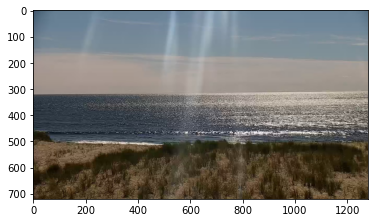

In [29]:
imfix = io.imread('~/Fog_Imaging_Project/sta_221/all_surfline_photos/2022_07-04.1900_pacificcityor.jpg')
plt.imshow(imfix)

In [30]:
grey_fix = rgb2gray(imfix)

In [32]:
grey_fix.max()

1.0

In [ ]:
patches = patchify(imfix, (360, 640, 3), (360))

patches_reshape = np.reshape(patches, (2*2*1, 360, 640, 3))
    # flattened_grey = patch_grey.ravel()
    patch_grey = rgb2gray(patch)

    mc = (flattened_grey.max()-flattened_grey.min()) / (flattened_grey.max()+flattened_grey.min())


In [34]:
print(sc.RMSContrastRatio(grey_fix))
print(sc.MichelsonContrastRatio(grey_fix))

0.452089872983516
1.0


In [6]:
# tofix.loc[tofix['dark_channel_prior_1'] < 0 ]
tofix[['dark_channel_prior_0', 'dark_channel_prior_1', 'dark_channel_prior_2', 'dark_channel_prior_3']].describe()



,dark_channel_prior_0,dark_channel_prior_1,dark_channel_prior_2,dark_channel_prior_3
count,8627.000000,8627.000000,8627.000000,8627.000000
mean,38.376029,37.271473,8.918280,9.864727
std,38.708001,45.429853,18.779084,20.966639
min,-128.000000,-128.000000,0.000000,0.000000
25%,3.000000,3.000000,0.000000,0.000000
50%,31.000000,29.000000,0.000000,0.000000
75%,67.000000,68.000000,7.000000,8.000000
max,127.000000,127.000000,113.000000,121.000000


In [7]:
tofix.loc[tofix['dark_channel_prior_1'] < 0 ]


,photo,Label,site,hour,mscn_var_0,mscn_var_1,mscn_var_2,mscn_var_3,vertical_var_0,vertical_var_1,...,dark_channel_prior_2,dark_channel_prior_3,color_sat_0,color_sat_1,color_sat_2,color_sat_3,CF_0,CF_1,CF_2,CF_3
1081,2022_07-14.0830_agatebeachor.jpg,foggy,agatebeachor,8,0.073823,0.083296,0.073233,0.071891,0.014612,0.016451,...,44.0,48.0,0.047731,0.035183,0.085300,0.073239,180.020305,180.875933,158.866033,151.656483
1349,2022_07-16.1830_cannonbeach.jpg,not_foggy,cannonbeach,18,0.204564,0.178146,0.427838,0.443832,0.064294,0.044905,...,0.0,0.0,0.032500,0.027322,0.092488,0.036193,164.484539,174.793509,80.490503,87.203167
1705,2022_07-20.0800_pacificcityor.jpg,foggy,pacificcityor,8,0.076456,0.072364,0.450410,0.443999,0.019266,0.018372,...,10.0,8.0,0.071231,0.069335,0.174083,0.186687,48.168960,42.047424,187.599024,186.153742
1710,2022_07-20.0830_pacificcityor.jpg,foggy,pacificcityor,8,0.068862,0.065298,0.325690,0.322417,0.017753,0.017087,...,28.0,28.0,0.041154,0.041246,0.132264,0.139896,48.316570,42.220341,187.386605,185.744730
1721,2022_07-20.1030_pacificcityor.jpg,foggy,pacificcityor,10,0.078130,0.075344,0.609640,0.591855,0.019130,0.018708,...,0.0,0.0,0.071033,0.067400,0.232664,0.248580,48.383726,42.804626,184.278432,183.308583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7841,2023_08-28.1230_pacificcityor.jpg,foggy,pacificcityor,12,0.101009,0.097111,0.595718,0.581940,0.024273,0.023847,...,0.0,0.0,0.057565,0.054957,0.364967,0.383507,50.078501,52.832996,187.302797,184.903734
7992,2023_09-04.0900_agatebeachor.jpg,foggy,agatebeachor,9,0.102459,0.099735,0.252930,0.228199,0.025212,0.025227,...,70.0,85.0,0.023841,0.020021,0.029072,0.034985,66.420064,39.999480,100.041430,125.385852
8184,2023_09-11.0930_otterrockor.jpg,foggy,otterrockor,9,0.076977,0.073819,0.230470,0.283968,0.019451,0.018553,...,0.0,0.0,0.023628,0.017290,0.053924,0.064923,44.416479,39.756470,99.305254,108.822370
8185,2023_09-11.0930_pacificcityor.jpg,foggy,pacificcityor,9,0.079237,0.074640,0.579889,0.586635,0.019884,0.018677,...,0.0,0.0,0.090635,0.091468,0.353267,0.376128,48.747153,43.211942,186.638939,188.624810


In [8]:
tofix.loc[1081]

photo                      2022_07-14.0830_agatebeachor.jpg
Label                                                 foggy
site                                           agatebeachor
hour                                                      8
mscn_var_0                                         0.073823
mscn_var_1                                         0.083296
mscn_var_2                                         0.073233
mscn_var_3                                         0.071891
vertical_var_0                                     0.014612
vertical_var_1                                     0.016451
vertical_var_2                                     0.014983
vertical_var_3                                     0.014865
sharpness_0                                        0.006008
sharpness_1                                        0.006192
sharpness_2                                        0.004816
sharpness_3                                        0.004667
coef_or_var_sharpness_0                 

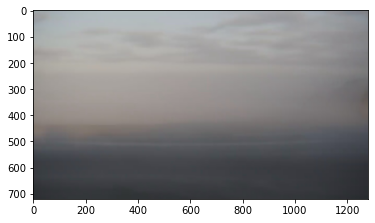

In [9]:
imfix = io.imread('~/Fog_Imaging_Project/sta_221/all_surfline_photos/2022_07-14.0830_agatebeachor.jpg')
plt.imshow(imfix)


In [10]:
patches = patchify(imfix, (360, 640, 3), (360))

patches_reshape = np.reshape(patches, (2*2*1, 360, 640, 3))


In [26]:
fog_aware_stats = pd.DataFrame(columns = ['photo', 'patch' ,'mscn_var','vertical_var','sharpness'
                                          ,'coef_or_var_sharpness','mc','entropy','dark_channel_prior','color_sat','CF'])

photo = '2022_07-14.0830_agatebeachor.jpg'
for i in range(len(patches_reshape)):

    ##get patch and convert it to greyscale and greyscale flattened
    patch = patches_reshape[i, :, :, :]
    patch_grey = rgb2gray(patch)
    flattened_grey = patch_grey.ravel()

    ### variance of mscn coefficients
    mscn = calculate_mscn_coefficients(patch_grey)
    mscn_var = mscn.var()

    ###variance of the vertical product if mscn coefficients (positive, negative mode)
    vertical = mscn[:-1, :] * mscn[1:, :]
    vertical_var = vertical.var()


    ###the sharpness
    ###the coefficient of vaiance of sharpness
    kernel_size=6
    sigma=7/6
    kernel = gaussian_kernel2d(kernel_size, sigma=sigma)
    local_mean = signal.convolve2d(patch_grey, kernel, 'same')
    local_var = local_deviation(patch_grey, local_mean, kernel)
    local_cv = local_var/local_mean
    flattened = patch_grey.ravel()
    sharpness = local_var.mean()
    coef_or_var_sharpness = local_cv.mean()

    ##the contrast energy

    ##michelsons contrast 
    mc = (flattened_grey.max()-flattened_grey.min()) / (flattened_grey.max()+flattened_grey.min())

    ###entropy (H)
    kde_results = gaussian_kde(flattened)

    # # Generate points to evaluate the KDE
    x = np.linspace(np.min(flattened), np.max(flattened), 100)
    H = stats.entropy(kde_results.pdf(x))


    ##the dark channel prior in a pixel-wise
    dark_channel_prior = patch.min()
    ### avoid weird type conversion of uint8 to object in pandas df
    dark_channel_prior = dark_channel_prior.astype('int64') 
    
    ##the color saturation in hsv color space
    saturation = rgb2hsv(patch)[:, :, 1] ##second channel in hue saturation value
    color_sat = saturation.mean()

    ##the colorfulness
    red = patch[:,:,0]
    green = patch[:,:,1]
    blue = patch[:,:,2]

    rg = -1*(green - red) ### it will be squared so order doesnt matter
    yb = .5 * (red + green) - blue
    CF = np.sqrt((rg.std())**2 + (yb.std())**2) + 0.3*np.sqrt((rg.mean())**2 + (yb.mean())**2)
    fog_aware_stats = pd.concat([
        fog_aware_stats,
    pd.DataFrame({
                 'photo':[photo]
                 , 'patch' :[i]
                 ,'mscn_var':[mscn_var ]
                 ,'vertical_var':[vertical_var]
                 ,'sharpness':[sharpness]
                 ,'coef_or_var_sharpness':[coef_or_var_sharpness]
                 ,'mc':[mc]
                 ,'entropy':[H]
                 ,'dark_channel_prior':[dark_channel_prior]
                 ,'color_sat':[color_sat]
                 ,'CF':[CF]
                 })
    ])

#         print(i)
#         print(len(fog_aware_stats))
# if (f % 1000 == 0):



138
128
44
48


In [27]:
fog_aware_stats

,photo,patch,mscn_var,vertical_var,sharpness,coef_or_var_sharpness,mc,entropy,dark_channel_prior,color_sat,CF
0,2022_07-14.0830_agatebeachor.jpg,0,0.073823,0.014612,0.006008,0.014307,0.128805,4.486470,138,0.047731,180.020305
0,2022_07-14.0830_agatebeachor.jpg,1,0.083296,0.016451,0.006192,0.014705,0.186276,4.430567,128,0.035183,180.875933
0,2022_07-14.0830_agatebeachor.jpg,2,0.073233,0.014983,0.004816,0.017176,0.533657,4.453118,44,0.085300,158.866033
0,2022_07-14.0830_agatebeachor.jpg,3,0.071891,0.014865,0.004667,0.017062,0.499577,4.448536,48,0.073239,151.656483


In [115]:
len(links_and_labels_loop)

8629

In [77]:
### variance of mscn coefficients

mscn = calculate_mscn_coefficients(patch_grey)
print(mscn.var())
mscn_var = mscn.var()
# plt.hist(mscn, bins = 50)

###variance of the vertical product if mscn coefficients (positive, negative mode)
vertical = mscn[:-1, :] * mscn[1:, :]
vertical_var = vertical.var()

###the sharpness
###the coefficient of vaiance of sharpness
kernel_size=6
sigma=7/6
kernel = gaussian_kernel2d(kernel_size, sigma=sigma)
local_mean = signal.convolve2d(patch_grey, kernel, 'same')
local_var = local_deviation(patch_grey, local_mean, kernel)
local_cv = local_var/local_mean
flattened = patch_grey.ravel()
sharpness = local_var.mean()
coef_or_var_sharpness = local_cv.mean()

0.28200020196393466


In [11]:
# all_mscn_pair_coefs = calculate_pair_product_coefficients(mscn)

In [55]:
# def plot_histogram(x, label):
#     n, bins = np.histogram(x.ravel(), bins=50)
#     n = n / np.max(n)
#     plt.plot(bins[:-1], n, label=label, marker='o')
# plot_histogram(mscn, 'mscn')

In [14]:

kernel_size=6
sigma=7/6
kernel = gaussian_kernel2d(kernel_size, sigma=sigma)
local_mean = signal.convolve2d(patch_grey, kernel, 'same')
local_var = local_deviation(patch_grey, local_mean, kernel)
local_cv = local_var/local_mean
flattened = patch_grey.ravel()
sharpness = local_var.mean()
coef_or_var_sharpness = local_cv.mean()

(76241,)
0.10202557624271232
0.030290309065345754


In [ ]:
##### contrast energy 

##michelsons contrast 
mc = (flattened.max()-flattened.min()) / (flattened.max()+flattened.min())
print(mc)
##the image entropy


In [ ]:
###entropy (H)
kde_results = gaussian_kde(flattened)

# # Generate points to evaluate the KDE
x = np.linspace(np.min(flattened), np.max(flattened), 100)
H = stats.entropy(kde_results.pdf(x))
print(len(H))
# # Calculate the normalized probabilities for each row
# probabilities = pdf_values / np.sum(pdf_values, axis=1)[:, np.newaxis]
H

In [52]:
###dark channel prior

# dark_channel_prior = np.min([
# patch[:,:,0].min()
#     ,patch[:,:,1].min()
#     ,patch[:,:,2].min()]
# )

dark_channel_prior = patch.min()

dark_channel_prior

82

In [50]:
##color saturation

saturation = rgb2hsv(patch)[:, :, 1] ##second channel in hue saturation value

In [49]:
# plt.imshow(rgb2hsv(patch)[:, :, 1], cmap='hsv')

In [ ]:

##colorfulness
##calc rg

red = patch[:,:,0]
green = patch[:,:,1]
blue = patch[:,:,2]

rg = -1*(green - red) ### it will be squared so order doesnt matter
yb = .5 * (red + green) - blue
CF = np.sqrt((rg.std())**2 + (yb.std())**2) + 0.3*np.sqrt((rg.mean())**2 + (yb.mean())**2)



In [ ]:
###convert into patches
###calculate fog aware stats for entire image

In [ ]:
for f in range(len(photo_info)):
    im = io.imread(image_dir + photo_info.loc[f, 'project_files_location']) ## read in file
    # im = im[110:950, :, :]
    if len(im.shape) == 3: ##if photo is in color then convert to black and white
        im = rgb2gray(im)
    if im.shape[0] == 960: ## rescale photo 96 x 128
        im = rescale(im, 0.05, anti_aliasing=False)
    else:
        im = rescale(im, 0.1, anti_aliasing=False)
## save the raw photo output 
    if f == 0 :
        with open("/home/smmrrr/Fog_Imaging_Project/images_flattened.csv",'w', newline='') as fd:
            writer = csv.writer(fd, delimiter=",")
            writer.writerow(im.ravel())
    else:
        with open("/home/smmrrr/Fog_Imaging_Project/images_flattened.csv",'a', newline='') as fd:
                writer = csv.writer(fd, delimiter=",")
                writer.writerow(im.ravel())
